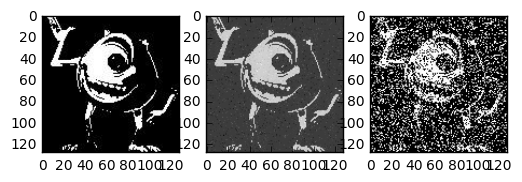

In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread
from scipy import signal
def add_gaussian_noise(im,prop,varSigma):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    e = varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
    im2 = np.copy(im)
    im2[index] = im2[index] + e[index]
    return im2
def add_saltnpeppar_noise(im,prop):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    im2 = np.copy(im)
    im2[index] = 1-im2[index]
    return im2
# proportion of pixels to alter
prop = 0.2
varSigma = 0.1
im = imread("../images/mike_small_grey.jpg")
im = im/255
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(im,cmap='gray')
im2 = add_gaussian_noise(im,prop,varSigma)
ax2 = fig.add_subplot(132)
ax2.imshow(im2,cmap='gray')
im2 = add_saltnpeppar_noise(im,prop)
ax3 = fig.add_subplot(133)
ax3.imshow(im2,cmap='gray')

In [2]:
def neighbours(i,j,M,N,size=4):
    if size==4:
        if (i==0 and j==0):
            n=[(0,1), (1,0)]
        elif i==0 and j==N-1:
            n=[(0,N-2), (1,N-1)]
        elif i==M-1 and j==0:
            n=[(M-1,1), (M-2,0)]
        elif i==M-1 and j==N-1:
            n=[(M-1,N-2), (M-2,N-1)]
        elif i==0:
            n=[(0,j-1), (0,j+1), (1,j)]
        elif i==M-1:
            n=[(M-1,j-1), (M-1,j+1), (M-2,j)]
        elif j==0:
            n=[(i-1,0), (i+1,0), (i,1)]
        elif j==N-1:
            n=[(i-1,N-1), (i+1,N-1), (i,N-2)]
        else:
            n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
        return n
    if size==8:
        print('Not yet implemented\n')
        #expand this to include diagonal elements
        return -1

(96, 128)
(1.4941840153786736, 1.4935840153786737)
(1.4944840153787005, 1.4932840153787006)
(4.4570361972904395, 4.4516909616365128)
checking if the convolution is same as manual
[[  3.92156863e-03   0.00000000e+00   1.53787005e-04 ...,   1.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.00392157e+00   1.02352941e+00   0.00000000e+00 ...,   2.00000000e+00
    1.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   4.65051903e-02   1.00710496e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   4.00000000e+00
    2.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   3.00000000e+00
    2.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   2.00000000e+00
    0.00000000e+00   0.00000000e+00]]
[[  3.92156863e-03   0.00000000e+00   1.53787005e-04 ...,   1.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.00392157e+00   1.023529

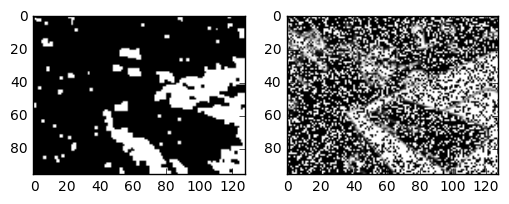

In [3]:
print(im2.shape)
latent_im2 = np.copy(im2)
# print(im2.item((34, 123)))
# print(im2.item((36, 123)))
# print(im2.item((33, 45)))

def heightWidth(image):
    #width is the bigger one, the second one
    return image.shape[0], image.shape[1]

def bookEnergyOld1(image, xImage, point):
    height, width = heightWidth(image)
    
    finalSumPos = 0
    finalSumNeg = 0
    for m in range(height):
        for n in range(width):
            if ((m, n) == point):
                finalSumPos += image.item((m, n)) * 1
                finalSumNeg += image.item((m, n)) * -1
            else:
                finalSumPos += image.item((m, n)) * xImage.item((m, n))
                finalSumNeg += image.item((m, n)) * xImage.item((m, n))
                
    return finalSumPos/10000, finalSumNeg/10000

def bookEnergyOld2(image, xImage, point):
    height, width = heightWidth(image)
                
    middleSumPos = 0
    middleSumNeg = 0
    posArr = np.copy(xImage)
    negArr = np.copy(posArr)
    for m in range(height):
        
        for n in range(width):
            neighbourList = neighbours(m, n, height, width, size=4)
            posArr[(m,n)] = 0
            negArr[(m,n)] = 0
            for neighbour in neighbourList:
                if ((m, n) == point):
                    middleSumPos += 1 * xImage.item(neighbour)
                    posArr[(m,n)] += 1* xImage.item(neighbour)
                    middleSumNeg += -1 * xImage.item(neighbour)
                    negArr[(m,n)] += -1* xImage.item(neighbour)
                else:
                    middleSumPos += xImage.item((m, n)) * xImage.item(neighbour)
                    posArr[(m,n)] += xImage.item((m, n)) * xImage.item(neighbour)
                    middleSumNeg += xImage.item((m, n)) * xImage.item(neighbour)
                    negArr[(m,n)] += xImage.item((m, n)) * xImage.item(neighbour)
                    
    return middleSumPos/10000, middleSumNeg/10000, posArr, negArr

def bookEnergyOld(image, xImage, point):
    posSum1, negSum1 = bookEnergyOld1(image, xImage, point)
    posSum2 = bookEnergyOld2(image, xImage, point)[0]
    negSum2 = bookEnergyOld2(image, xImage, point)[1]
    return posSum1+posSum2, negSum1+negSum2
    
def bookEnergy(image, xImage, point):
    #last term
    height, width = heightWidth(image)
    
    kernel = np.array([[0,1,0],
                       [1,0,1],
                       [0,1,0]])
    xImage[point] = 1
    XY_multiplied_pos = np.multiply(image, xImage)
    finalSumPos = np.sum(XY_multiplied_pos)
    XN_convolved_pos = signal.convolve2d(xImage, kernel, mode='same')
    XN_multiplied_pos = np.multiply(xImage, XN_convolved_pos)
    middleSumPos = np.sum(XN_multiplied_pos)
    
    xImage[point] = -1
    XY_multiplied_neg = np.multiply(image, xImage)    
    finalSumNeg = np.sum(XY_multiplied_neg)
    XN_convolved_neg = signal.convolve2d(xImage, kernel, mode='same')
    XN_multiplied_neg = np.multiply(xImage, XN_convolved_neg)
    middleSumNeg = np.sum(XN_multiplied_neg)   
#     middleSumPos = 0
#     middleSumNeg = 0
    totalSumPos = finalSumPos + middleSumPos
    totalSumNeg = finalSumNeg + middleSumNeg
    return totalSumPos/10000, totalSumNeg/10000
    
def jointProb(image, xImage, point):
    Z = 1
    posEnergy, negEnergy = bookEnergy(image, xImage, point)
    posVal = 1/Z * np.exp(posEnergy)
    negVal = 1/Z * np.exp(negEnergy)
    return posVal, negVal

print(bookEnergyOld(im2, latent_im2, (34, 123)))
print(bookEnergy(im2, latent_im2, (34, 123)))
print(jointProb(im2, latent_im2, (34, 123)))

print("checking if the convolution is same as manual")

manualP = bookEnergyOld2(im2, latent_im2, (34, 123))[2]

kernel = np.array([[0,1,0],
                   [1,0,1],
                   [0,1,0]])

latent_im2[(34, 123)] = 1
convoP = signal.convolve2d(latent_im2, kernel, mode='same')
convomP = np.multiply(convoP, latent_im2)

print(manualP)
print(convomP)

print("It is ", np.array_equal(manualP, convomP), " that they are the same array")
print()
print("checking if the convolution is same as manual, negative")

latent_im2 = np.copy(im2)
manualN = bookEnergyOld2(im2, latent_im2, (34, 123))[3]

latent_im2[(34, 123)] = -1
convoN = signal.convolve2d(latent_im2, kernel, mode='same')
convomN = np.multiply(convoN, latent_im2)

print(manualN)
print(convomN)
print("It is ", np.array_equal(manualN, convomN), " that they are the same array")
print()


    
def ICM(image):
    #set all the x variables to be = y variables
    #i.e. all the latent variables initialised as the image output
    H, W = heightWidth(image)
    X = np.copy(image)
    X[X != 1] = -1
    print(X)
    print("initialised X i.e. latent image")
    for iterations in range(2):
        flag = False
        for i in range(H):
            for j in range(W):
                point = (i,j)
                probPos, probNeg = jointProb(image, X, point)
                if(probPos > probNeg):
                    if(X[point] == -1):
                        flag = True
                        X[point] = 1
                elif(probNeg > probPos):
                    if(X[point] == 1):
                        print("yah")
                        flag = True
                        X[point] = -1
        if(flag == False):
            print("bail early")
            break
        print("one iteration of ICM done")
    print("We compeleted ", iterations+1, " iterations")
    
    X[X != 1] = 0
    
    return X

imFIXED = ICM(im2)

print(np.array_equal(im2, imFIXED))

print(imFIXED.item((34, 123)))
print(imFIXED.item((36, 123)))
print(imFIXED.item((33, 45)))

fig = plt.figure()
ax = fig.add_subplot(121)
ax.imshow(imFIXED,cmap='gray')
ax2 = fig.add_subplot(122)
ax2.imshow(im2,cmap='gray')
plt.show()

In [6]:
kernel = np.array([[0,1,0],
                   [1,0,1],
                   [0,1,0]])

array = np.array([[ 1, -1,  1,  1, -1,  1],
                 [ -1,  1, -1,  1,  1, -1],
                 [  1,  1,  1,  1, -1, -1],
                 [  1,  1,  1,  1,  1,  1]])

point = (3, 5)

array[point] = -1
print("\n", array, "\n")
convol = signal.convolve2d(array, kernel, mode='same')
final = np.multiply(array, convol)
print(final)

h, w = heightWidth(array)

itSum = 0
for i in range(h):
    for j in range(w):
        ns = neighbours(i, j, h, w, size=4)
        for n in ns:
            itSum += array[n] * array[(i,j)]
            
print(itSum)
print(np.sum(final))

array[point] = -1
print("\n", array, "\n")
print(signal.convolve2d(array, kernel, mode='same'))
print(array[point])



 [[ 1 -1  1  1 -1  1]
 [-1  1 -1  1  1 -1]
 [ 1  1  1  1 -1 -1]
 [ 1  1  1  1  1 -1]] 

[[-2 -3 -1  1 -3 -2]
 [-3 -2 -4  2 -2 -1]
 [ 1  4  2  2 -2  3]
 [ 2  3  3  3 -1  0]]
0
0

 [[ 1 -1  1  1 -1  1]
 [-1  1 -1  1  1 -1]
 [ 1  1  1  1 -1 -1]
 [ 1  1  1  1  1 -1]] 

[[-2  3 -1  1  3 -2]
 [ 3 -2  4  2 -2  1]
 [ 1  4  2  2  2 -3]
 [ 2  3  3  3 -1  0]]
-1


(4763.2267589388694, 4763.2267589388694)
(8142.2280968858131, 8140.2280968858131)
(405830.21032455628, 403355.06309006823)


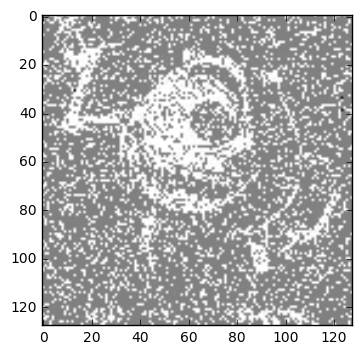

initialised latent image = corrupted image


In [ ]:
def likeli(image, xImage, point):
    xImage[point] = 1
    multipliedArrayPos = np.multiply(image, xImage)
    arraySumPos = np.sum(multipliedArrayPos)
    
    xImage[point] = -1
    multipliedArrayNeg = np.multiply(image, xImage)
    arraySumNeg = np.sum(multipliedArrayNeg)
    return arraySumPos, arraySumNeg
  
def E0(xImage, point):
    kernel = np.array([[0,1,0],
                       [1,0,1],
                       [0,1,0]])
    xImage[point] = 1
    xConvolvedPos = signal.convolve2d(xImage, kernel, mode='same')
    xMultiplyPos = np.multiply(xImage, xConvolvedPos)
    xSumPos = np.sum(xMultiplyPos)
    xImage[point] = -1
    xConvolvedNeg = signal.convolve2d(xImage, kernel, mode='same')
    xMultiplyNeg = np.multiply(xImage, xConvolvedPos)
    xSumNeg = np.sum(xMultiplyNeg)
    return xSumPos, xSumNeg
    
def prob(image, xImage, point):
    #p(y|x) = e^likeli
    #p(x) = e^E0
    #p(x, y) = p(y|x) * p(x)
    #we scale by a factor of 1000 for ease of calculation.
    #The results are not affected.
    
    L_pos, L_neg = likeli(image, xImage, point)
    E_pos, E_neg = E0(xImage, point)
    pYX_pos, pYX_neg = np.exp(L_pos/1000), np.exp(L_neg/1000)
    pX_pos, pX_neg = np.exp(E_pos/1000), np.exp(E_neg/1000)
    
    pXY_pos, pXY_neg = pYX_pos * pX_pos, pYX_neg * pX_neg
    
    return pXY_pos, pXY_neg

print(likeli(im2, im2, (39, 123)))
print(E0(im2, (34, 123)))
print(prob(im2, im2, (31, 13)))

def ICM2(image, lim):
    H, W = heightWidth(image)
    X = np.copy(image)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.imshow(im2,cmap='gray')
    plt.show()
    print("initialised latent image = corrupted image")
    for iterations in range(lim):
        for i in range(H):
            for j in range(W):
                point = (i, j)
                prob_pos, prob_neg = prob(image, X, point)
                if(prob_pos > prob_neg):
                    X[point] = 1
                else:
                    X[point] = -1
        fign = plt.figure()
        ax2 = fign.add_subplot(111)
        ax2.imshow(X,cmap='gray')
        plt.show()
        print("one iteration done")
    print("We have completed ", iterations+1, " iterations")
    
    return X

imFIXED2 = ICM2(im2, 20)